In [1]:
from keras.layers import *
import keras
from keras.models import Model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras import backend as K

ModuleNotFoundError: No module named 'keras'

# Setup Google CoLab Environment

In [3]:
# Import data on Google CoLab
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Colab\ Notebooks/2.\ Autoencoder

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/2. Autoencoder


# Importing relevant functions and libraries

In [3]:
%run "Reusable_Functions.ipynb"

# Import Data

In [4]:
# Import data offline
cplr_noisy = import_DB('db6_5SS_noisy_s20084.npz')
print(cplr_noisy.shape)
cplr_true = import_DB('db4_5SS_mirror_s20084.npz')
print(cplr_true.shape)

(20084, 100, 3)
(20084, 100, 3)


In [5]:
data_max=np.max([np.max(cplr_noisy),np.max(cplr_true)])
data_min=np.min([np.min(cplr_noisy),np.min(cplr_true)])
print(data_max)
print(np.abs(data_min))

0.5570395753847958
0.5682779550021021


In [6]:
# Renormalize DB from range [-1,1] to range [0,1] 
n_cplr_true=cplr_true/(np.abs(data_min)+data_max)+np.abs(data_min)
n_cplr_noisy=cplr_noisy/(np.abs(data_min)+data_max)+np.abs(data_min)

# Splitting the database in Train/Test dataset

In [7]:
x= n_cplr_noisy
y= n_cplr_true

# Split data into training and testing dataset
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(16067, 100, 3)
(16067, 100, 3)
(4017, 100, 3)
(4017, 100, 3)


In [8]:
def sampling(args):
    mu, log_var = args
    batch_size = K.shape(mu)[0]
    z_dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch_size, z_dim))
    return mu + K.exp(0.5 * log_var) * eps

def rmse(y_true, y_pred):
  dist=K.sqrt(K.sum(K.square(y_pred - y_true),axis=-1)) # Dim(batch,pts)
  return K.sum(dist,axis=-1) # Dim(batch)

def kl(z_mean,z_log_var):
  return 0.5 * K.sum(K.square(z_mean) + K.exp(z_log_var) - z_log_var - 1, axis=-1)

# Variational Autoencoder (VAE)

## Fully Connected (hidden=1, Z=30)

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 100, 3)       0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 300)          0           input_10[0][0]                   
__________________________________________________________________________________________________
dense_64 (Dense)                (None, 150)          45150       flatten_10[0][0]                 
__________________________________________________________________________________________________
dense_65 (Dense)                (None, 150)          22650       dense_64[0][0]                   
___________________________________________________________________________________________

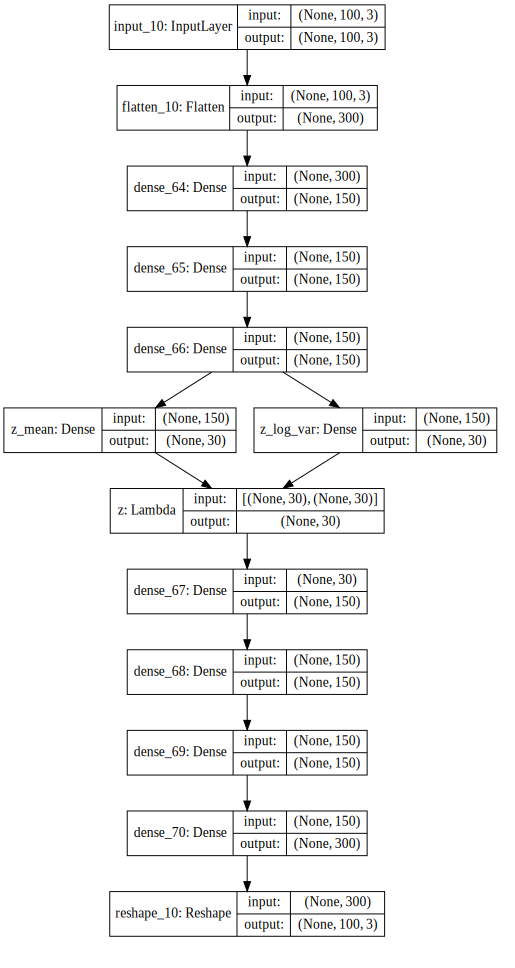

In [47]:
def VAE_FC_h1_Z30():
    z_dim=30
    inp=Input(shape=(100,3))

    # Encoding
    x=Flatten()(inp)
    x=Dense(100, activation='relu')(x)
    z_mean = Dense(z_dim, name='z_mean')(x)
    z_log_var = Dense(z_dim, name='z_log_var')(x)
    z = Lambda(sampling, output_shape=(z_dim,), name='z')([z_mean, z_log_var])

    # Decoding
    x=Dense(100, activation='relu')(z)
    x=Dense(300)(x)
    y=Reshape((100, 3))(x)
    
    # loss
    def reconstruction_loss(out_true, out_pred):
      return rmse(out_true, out_pred)
    def kl_loss(out_true, out_pred):
      return kl(z_mean,z_log_var)
    def vae_loss(out_true, out_pred):      
      return reconstruction_loss(out_true, out_pred) + kl_loss(out_true, out_pred)

    # build model
    vae = Model(inputs=[inp], outputs=[y])
    #vae.add_loss(vae_loss)
    vae.compile(optimizer='adam', loss=vae_loss, metrics=[reconstruction_loss,kl_loss])
    vae.summary()
    
    encoder = Model(inputs=[inp], outputs=[z_mean])
    return vae, encoder

vae,_=VAE_FC_h1_Z30()
SVG(model_to_dot(vae, show_shapes='true', show_layer_names='true', dpi=70).create(prog='dot', format='svg'))

In [48]:
#resetRNG(0)
#x_train_3D=np.expand_dims(x_train, 4)
#x_test_3D=np.expand_dims(x_test, 4)
#AE,E,train_data =AE_analysis(VAE_Z30, 10, x_train, x_test, filename='VAE_Z30')

train_data=vae.fit([x_train], [y_train], shuffle=True, epochs=3000, batch_size=256, validation_data=([x_test], [y_test]), verbose=1)

Train on 16067 samples, validate on 4017 samples
Epoch 1/3000
16067/16067 [==============================] - 0s 28us/step - loss: 35.7999 - reconstruction_loss: 35.4390 - kl_loss: 0.3609 - val_loss: 20.2469 - val_reconstruction_loss: 20.1287 - val_kl_loss: 0.1182
Epoch 2/3000
16067/16067 [==============================] - 0s 13us/step - loss: 18.8270 - reconstruction_loss: 18.7400 - kl_loss: 0.0870 - val_loss: 17.6843 - val_reconstruction_loss: 17.6239 - val_kl_loss: 0.0604
Epoch 3/3000
16067/16067 [==============================] - 0s 14us/step - loss: 17.0150 - reconstruction_loss: 16.9409 - kl_loss: 0.0741 - val_loss: 16.3400 - val_reconstruction_loss: 16.2437 - val_kl_loss: 0.0963
Epoch 4/3000
16067/16067 [==============================] - 0s 14us/step - loss: 15.2729 - reconstruction_loss: 14.7642 - kl_loss: 0.5087 - val_loss: 12.6251 - val_reconstruction_loss: 11.0315 - val_kl_loss: 1.5936
Epoch 5/3000
16067/16067 [==============================] - 0s 13us/step - loss: 11.4954 - 

Epoch 78/3000
16067/16067 [==============================] - 0s 14us/step - loss: 7.4062 - reconstruction_loss: 5.4341 - kl_loss: 1.9721 - val_loss: 7.4161 - val_reconstruction_loss: 5.4441 - val_kl_loss: 1.9720
Epoch 79/3000
16067/16067 [==============================] - 0s 13us/step - loss: 7.4002 - reconstruction_loss: 5.4046 - kl_loss: 1.9957 - val_loss: 7.4764 - val_reconstruction_loss: 5.5012 - val_kl_loss: 1.9752
Epoch 80/3000
16067/16067 [==============================] - 0s 14us/step - loss: 7.4011 - reconstruction_loss: 5.4177 - kl_loss: 1.9834 - val_loss: 7.4837 - val_reconstruction_loss: 5.4429 - val_kl_loss: 2.0408
Epoch 81/3000
16067/16067 [==============================] - 0s 14us/step - loss: 7.3810 - reconstruction_loss: 5.4069 - kl_loss: 1.9741 - val_loss: 7.5707 - val_reconstruction_loss: 5.6159 - val_kl_loss: 1.9548
Epoch 82/3000
16067/16067 [==============================] - 0s 14us/step - loss: 7.3818 - reconstruction_loss: 5.4136 - kl_loss: 1.9682 - val_loss: 7.4

16067/16067 [==============================] - 0s 13us/step - loss: 7.1797 - reconstruction_loss: 5.0738 - kl_loss: 2.1058 - val_loss: 7.3989 - val_reconstruction_loss: 5.2260 - val_kl_loss: 2.1729
Epoch 155/3000
16067/16067 [==============================] - 0s 14us/step - loss: 7.1982 - reconstruction_loss: 5.0888 - kl_loss: 2.1094 - val_loss: 7.3547 - val_reconstruction_loss: 5.3080 - val_kl_loss: 2.0467
Epoch 156/3000
16067/16067 [==============================] - 0s 14us/step - loss: 7.1989 - reconstruction_loss: 5.1011 - kl_loss: 2.0978 - val_loss: 7.3464 - val_reconstruction_loss: 5.1550 - val_kl_loss: 2.1914
Epoch 157/3000
16067/16067 [==============================] - 0s 14us/step - loss: 7.1907 - reconstruction_loss: 5.0870 - kl_loss: 2.1037 - val_loss: 7.3236 - val_reconstruction_loss: 5.2265 - val_kl_loss: 2.0971
Epoch 158/3000
16067/16067 [==============================] - 0s 13us/step - loss: 7.2451 - reconstruction_loss: 5.1457 - kl_loss: 2.0994 - val_loss: 7.3679 - val_

16067/16067 [==============================] - 0s 14us/step - loss: 7.2887 - reconstruction_loss: 5.2534 - kl_loss: 2.0353 - val_loss: 7.4067 - val_reconstruction_loss: 5.4328 - val_kl_loss: 1.9740
Epoch 231/3000
16067/16067 [==============================] - 0s 14us/step - loss: 7.2673 - reconstruction_loss: 5.2345 - kl_loss: 2.0328 - val_loss: 7.3137 - val_reconstruction_loss: 5.2666 - val_kl_loss: 2.0472
Epoch 232/3000
16067/16067 [==============================] - 0s 14us/step - loss: 7.2747 - reconstruction_loss: 5.2569 - kl_loss: 2.0178 - val_loss: 7.3722 - val_reconstruction_loss: 5.3479 - val_kl_loss: 2.0242
Epoch 233/3000
16067/16067 [==============================] - 0s 14us/step - loss: 7.2768 - reconstruction_loss: 5.2147 - kl_loss: 2.0621 - val_loss: 7.4261 - val_reconstruction_loss: 5.4078 - val_kl_loss: 2.0184
Epoch 234/3000
16067/16067 [==============================] - 0s 14us/step - loss: 7.2817 - reconstruction_loss: 5.2420 - kl_loss: 2.0397 - val_loss: 7.5044 - val_

16067/16067 [==============================] - 0s 14us/step - loss: 7.0467 - reconstruction_loss: 4.8296 - kl_loss: 2.2171 - val_loss: 7.0694 - val_reconstruction_loss: 4.8446 - val_kl_loss: 2.2248
Epoch 307/3000
16067/16067 [==============================] - 0s 14us/step - loss: 7.0256 - reconstruction_loss: 4.8262 - kl_loss: 2.1994 - val_loss: 7.3209 - val_reconstruction_loss: 5.1473 - val_kl_loss: 2.1735
Epoch 308/3000
16067/16067 [==============================] - 0s 13us/step - loss: 7.2636 - reconstruction_loss: 5.1122 - kl_loss: 2.1515 - val_loss: 7.1359 - val_reconstruction_loss: 4.9229 - val_kl_loss: 2.2131
Epoch 309/3000
16067/16067 [==============================] - 0s 14us/step - loss: 7.0916 - reconstruction_loss: 4.8806 - kl_loss: 2.2110 - val_loss: 7.0866 - val_reconstruction_loss: 4.8385 - val_kl_loss: 2.2481
Epoch 310/3000
16067/16067 [==============================] - 0s 13us/step - loss: 7.0085 - reconstruction_loss: 4.7872 - kl_loss: 2.2213 - val_loss: 7.0276 - val_

16067/16067 [==============================] - 0s 13us/step - loss: 6.9945 - reconstruction_loss: 4.7451 - kl_loss: 2.2494 - val_loss: 7.0682 - val_reconstruction_loss: 4.7733 - val_kl_loss: 2.2949
Epoch 383/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.9672 - reconstruction_loss: 4.6887 - kl_loss: 2.2785 - val_loss: 7.0212 - val_reconstruction_loss: 4.7783 - val_kl_loss: 2.2429
Epoch 384/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.9970 - reconstruction_loss: 4.7456 - kl_loss: 2.2513 - val_loss: 7.0793 - val_reconstruction_loss: 4.8358 - val_kl_loss: 2.2435
Epoch 385/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.9710 - reconstruction_loss: 4.7208 - kl_loss: 2.2503 - val_loss: 7.0259 - val_reconstruction_loss: 4.7470 - val_kl_loss: 2.2788
Epoch 386/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.9492 - reconstruction_loss: 4.6709 - kl_loss: 2.2783 - val_loss: 7.0305 - val_

16067/16067 [==============================] - 0s 14us/step - loss: 6.9011 - reconstruction_loss: 4.5838 - kl_loss: 2.3173 - val_loss: 6.9984 - val_reconstruction_loss: 4.6399 - val_kl_loss: 2.3585
Epoch 459/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.9037 - reconstruction_loss: 4.5827 - kl_loss: 2.3210 - val_loss: 7.0106 - val_reconstruction_loss: 4.7511 - val_kl_loss: 2.2596
Epoch 460/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.8951 - reconstruction_loss: 4.5551 - kl_loss: 2.3400 - val_loss: 6.9980 - val_reconstruction_loss: 4.6872 - val_kl_loss: 2.3108
Epoch 461/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.9509 - reconstruction_loss: 4.6387 - kl_loss: 2.3122 - val_loss: 6.9660 - val_reconstruction_loss: 4.5546 - val_kl_loss: 2.4114
Epoch 462/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.9133 - reconstruction_loss: 4.5645 - kl_loss: 2.3489 - val_loss: 6.9590 - val_

16067/16067 [==============================] - 0s 13us/step - loss: 6.8897 - reconstruction_loss: 4.5390 - kl_loss: 2.3507 - val_loss: 7.1029 - val_reconstruction_loss: 4.8040 - val_kl_loss: 2.2989
Epoch 535/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.9109 - reconstruction_loss: 4.5693 - kl_loss: 2.3415 - val_loss: 7.0375 - val_reconstruction_loss: 4.7191 - val_kl_loss: 2.3185
Epoch 536/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.9097 - reconstruction_loss: 4.5246 - kl_loss: 2.3851 - val_loss: 7.0452 - val_reconstruction_loss: 4.6236 - val_kl_loss: 2.4215
Epoch 537/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.8751 - reconstruction_loss: 4.5228 - kl_loss: 2.3523 - val_loss: 6.9126 - val_reconstruction_loss: 4.5947 - val_kl_loss: 2.3180
Epoch 538/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.8855 - reconstruction_loss: 4.5175 - kl_loss: 2.3679 - val_loss: 6.9514 - val_

16067/16067 [==============================] - 0s 13us/step - loss: 7.0326 - reconstruction_loss: 4.6481 - kl_loss: 2.3845 - val_loss: 7.0073 - val_reconstruction_loss: 4.6535 - val_kl_loss: 2.3538
Epoch 611/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.8333 - reconstruction_loss: 4.4474 - kl_loss: 2.3859 - val_loss: 6.8777 - val_reconstruction_loss: 4.4973 - val_kl_loss: 2.3804
Epoch 612/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.7672 - reconstruction_loss: 4.3530 - kl_loss: 2.4142 - val_loss: 6.8627 - val_reconstruction_loss: 4.4145 - val_kl_loss: 2.4482
Epoch 613/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.8203 - reconstruction_loss: 4.3939 - kl_loss: 2.4264 - val_loss: 6.8966 - val_reconstruction_loss: 4.5001 - val_kl_loss: 2.3965
Epoch 614/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.8117 - reconstruction_loss: 4.3958 - kl_loss: 2.4159 - val_loss: 6.8949 - val_

16067/16067 [==============================] - 0s 14us/step - loss: 6.7869 - reconstruction_loss: 4.3343 - kl_loss: 2.4526 - val_loss: 6.8744 - val_reconstruction_loss: 4.4252 - val_kl_loss: 2.4492
Epoch 687/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.8069 - reconstruction_loss: 4.3506 - kl_loss: 2.4563 - val_loss: 6.9713 - val_reconstruction_loss: 4.5079 - val_kl_loss: 2.4634
Epoch 688/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.8225 - reconstruction_loss: 4.3477 - kl_loss: 2.4748 - val_loss: 6.8647 - val_reconstruction_loss: 4.4187 - val_kl_loss: 2.4461
Epoch 689/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.8604 - reconstruction_loss: 4.4042 - kl_loss: 2.4562 - val_loss: 6.9620 - val_reconstruction_loss: 4.5796 - val_kl_loss: 2.3824
Epoch 690/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.8187 - reconstruction_loss: 4.3830 - kl_loss: 2.4357 - val_loss: 6.8690 - val_

16067/16067 [==============================] - 0s 13us/step - loss: 6.8914 - reconstruction_loss: 4.5217 - kl_loss: 2.3697 - val_loss: 7.0359 - val_reconstruction_loss: 4.6039 - val_kl_loss: 2.4320
Epoch 763/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.8940 - reconstruction_loss: 4.4762 - kl_loss: 2.4178 - val_loss: 6.9518 - val_reconstruction_loss: 4.4496 - val_kl_loss: 2.5022
Epoch 764/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.8843 - reconstruction_loss: 4.3905 - kl_loss: 2.4938 - val_loss: 6.9364 - val_reconstruction_loss: 4.4050 - val_kl_loss: 2.5314
Epoch 765/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.8987 - reconstruction_loss: 4.3969 - kl_loss: 2.5018 - val_loss: 6.9776 - val_reconstruction_loss: 4.5292 - val_kl_loss: 2.4485
Epoch 766/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.8121 - reconstruction_loss: 4.3379 - kl_loss: 2.4742 - val_loss: 6.8429 - val_

16067/16067 [==============================] - 0s 14us/step - loss: 6.8171 - reconstruction_loss: 4.3475 - kl_loss: 2.4696 - val_loss: 6.8496 - val_reconstruction_loss: 4.4128 - val_kl_loss: 2.4368
Epoch 839/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.7633 - reconstruction_loss: 4.2729 - kl_loss: 2.4904 - val_loss: 6.8297 - val_reconstruction_loss: 4.3228 - val_kl_loss: 2.5069
Epoch 840/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.7482 - reconstruction_loss: 4.2437 - kl_loss: 2.5045 - val_loss: 6.8261 - val_reconstruction_loss: 4.3293 - val_kl_loss: 2.4968
Epoch 841/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.7559 - reconstruction_loss: 4.2746 - kl_loss: 2.4813 - val_loss: 6.8698 - val_reconstruction_loss: 4.3642 - val_kl_loss: 2.5056
Epoch 842/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.7776 - reconstruction_loss: 4.2945 - kl_loss: 2.4831 - val_loss: 6.8100 - val_

16067/16067 [==============================] - 0s 13us/step - loss: 6.8114 - reconstruction_loss: 4.3368 - kl_loss: 2.4746 - val_loss: 7.2255 - val_reconstruction_loss: 4.7171 - val_kl_loss: 2.5084
Epoch 915/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.9347 - reconstruction_loss: 4.5375 - kl_loss: 2.3972 - val_loss: 6.9151 - val_reconstruction_loss: 4.5187 - val_kl_loss: 2.3965
Epoch 916/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.7746 - reconstruction_loss: 4.3232 - kl_loss: 2.4514 - val_loss: 6.9882 - val_reconstruction_loss: 4.4807 - val_kl_loss: 2.5075
Epoch 917/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.8380 - reconstruction_loss: 4.3981 - kl_loss: 2.4399 - val_loss: 6.8743 - val_reconstruction_loss: 4.4387 - val_kl_loss: 2.4356
Epoch 918/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.7603 - reconstruction_loss: 4.3048 - kl_loss: 2.4554 - val_loss: 6.8571 - val_

16067/16067 [==============================] - 0s 14us/step - loss: 6.9643 - reconstruction_loss: 4.5531 - kl_loss: 2.4112 - val_loss: 7.1775 - val_reconstruction_loss: 4.7257 - val_kl_loss: 2.4517
Epoch 991/3000
16067/16067 [==============================] - 0s 14us/step - loss: 7.0173 - reconstruction_loss: 4.5990 - kl_loss: 2.4183 - val_loss: 7.0739 - val_reconstruction_loss: 4.6509 - val_kl_loss: 2.4230
Epoch 992/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.8765 - reconstruction_loss: 4.4570 - kl_loss: 2.4195 - val_loss: 6.9233 - val_reconstruction_loss: 4.5098 - val_kl_loss: 2.4135
Epoch 993/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.9023 - reconstruction_loss: 4.4871 - kl_loss: 2.4152 - val_loss: 7.6887 - val_reconstruction_loss: 5.3990 - val_kl_loss: 2.2897
Epoch 994/3000
16067/16067 [==============================] - 0s 13us/step - loss: 7.3490 - reconstruction_loss: 4.9695 - kl_loss: 2.3794 - val_loss: 7.0957 - val_

16067/16067 [==============================] - 0s 14us/step - loss: 6.8054 - reconstruction_loss: 4.3608 - kl_loss: 2.4446 - val_loss: 6.9081 - val_reconstruction_loss: 4.4535 - val_kl_loss: 2.4546
Epoch 1067/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.7730 - reconstruction_loss: 4.3101 - kl_loss: 2.4629 - val_loss: 6.9099 - val_reconstruction_loss: 4.4467 - val_kl_loss: 2.4631
Epoch 1068/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.7504 - reconstruction_loss: 4.2698 - kl_loss: 2.4805 - val_loss: 6.8331 - val_reconstruction_loss: 4.3799 - val_kl_loss: 2.4531
Epoch 1069/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.7978 - reconstruction_loss: 4.3372 - kl_loss: 2.4606 - val_loss: 6.9078 - val_reconstruction_loss: 4.4722 - val_kl_loss: 2.4356
Epoch 1070/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.7936 - reconstruction_loss: 4.3560 - kl_loss: 2.4376 - val_loss: 6.8721 - 

16067/16067 [==============================] - 0s 13us/step - loss: 6.8693 - reconstruction_loss: 4.4262 - kl_loss: 2.4431 - val_loss: 6.9487 - val_reconstruction_loss: 4.5249 - val_kl_loss: 2.4238
Epoch 1143/3000
16067/16067 [==============================] - 0s 13us/step - loss: 7.0037 - reconstruction_loss: 4.5332 - kl_loss: 2.4705 - val_loss: 7.0907 - val_reconstruction_loss: 4.7591 - val_kl_loss: 2.3315
Epoch 1144/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.8937 - reconstruction_loss: 4.4199 - kl_loss: 2.4738 - val_loss: 6.8561 - val_reconstruction_loss: 4.3739 - val_kl_loss: 2.4822
Epoch 1145/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.7687 - reconstruction_loss: 4.2894 - kl_loss: 2.4793 - val_loss: 6.8189 - val_reconstruction_loss: 4.3309 - val_kl_loss: 2.4879
Epoch 1146/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.8124 - reconstruction_loss: 4.3064 - kl_loss: 2.5060 - val_loss: 7.2898 - 

16067/16067 [==============================] - 0s 13us/step - loss: 6.7906 - reconstruction_loss: 4.2529 - kl_loss: 2.5377 - val_loss: 6.8638 - val_reconstruction_loss: 4.3462 - val_kl_loss: 2.5176
Epoch 1219/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.7651 - reconstruction_loss: 4.2413 - kl_loss: 2.5238 - val_loss: 6.8513 - val_reconstruction_loss: 4.3545 - val_kl_loss: 2.4968
Epoch 1220/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.7507 - reconstruction_loss: 4.2666 - kl_loss: 2.4841 - val_loss: 6.7963 - val_reconstruction_loss: 4.2869 - val_kl_loss: 2.5094
Epoch 1221/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.7401 - reconstruction_loss: 4.2248 - kl_loss: 2.5154 - val_loss: 6.8492 - val_reconstruction_loss: 4.2953 - val_kl_loss: 2.5539
Epoch 1222/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.8222 - reconstruction_loss: 4.2579 - kl_loss: 2.5643 - val_loss: 7.0096 - 

16067/16067 [==============================] - 0s 14us/step - loss: 6.7392 - reconstruction_loss: 4.2239 - kl_loss: 2.5152 - val_loss: 6.8103 - val_reconstruction_loss: 4.2780 - val_kl_loss: 2.5323
Epoch 1295/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.7398 - reconstruction_loss: 4.2228 - kl_loss: 2.5171 - val_loss: 6.8228 - val_reconstruction_loss: 4.3129 - val_kl_loss: 2.5099
Epoch 1296/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.9845 - reconstruction_loss: 4.5584 - kl_loss: 2.4262 - val_loss: 7.0820 - val_reconstruction_loss: 4.6368 - val_kl_loss: 2.4451
Epoch 1297/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.8395 - reconstruction_loss: 4.3539 - kl_loss: 2.4856 - val_loss: 6.8500 - val_reconstruction_loss: 4.3609 - val_kl_loss: 2.4891
Epoch 1298/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.7422 - reconstruction_loss: 4.2554 - kl_loss: 2.4868 - val_loss: 6.8116 - 

16067/16067 [==============================] - 0s 13us/step - loss: 6.7643 - reconstruction_loss: 4.2206 - kl_loss: 2.5438 - val_loss: 6.9590 - val_reconstruction_loss: 4.3658 - val_kl_loss: 2.5932
Epoch 1371/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.7160 - reconstruction_loss: 4.1655 - kl_loss: 2.5504 - val_loss: 6.7953 - val_reconstruction_loss: 4.2027 - val_kl_loss: 2.5925
Epoch 1372/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.7322 - reconstruction_loss: 4.1729 - kl_loss: 2.5593 - val_loss: 6.8707 - val_reconstruction_loss: 4.3898 - val_kl_loss: 2.4809
Epoch 1373/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.7815 - reconstruction_loss: 4.2487 - kl_loss: 2.5328 - val_loss: 6.8073 - val_reconstruction_loss: 4.2429 - val_kl_loss: 2.5644
Epoch 1374/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.7486 - reconstruction_loss: 4.2396 - kl_loss: 2.5090 - val_loss: 6.8318 - 

16067/16067 [==============================] - 0s 14us/step - loss: 6.7911 - reconstruction_loss: 4.2470 - kl_loss: 2.5442 - val_loss: 6.8982 - val_reconstruction_loss: 4.4159 - val_kl_loss: 2.4823
Epoch 1447/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.7879 - reconstruction_loss: 4.2548 - kl_loss: 2.5330 - val_loss: 6.8471 - val_reconstruction_loss: 4.3361 - val_kl_loss: 2.5110
Epoch 1448/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.8471 - reconstruction_loss: 4.3123 - kl_loss: 2.5348 - val_loss: 7.0327 - val_reconstruction_loss: 4.3843 - val_kl_loss: 2.6484
Epoch 1449/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.7887 - reconstruction_loss: 4.1921 - kl_loss: 2.5966 - val_loss: 6.8412 - val_reconstruction_loss: 4.2743 - val_kl_loss: 2.5669
Epoch 1450/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.7540 - reconstruction_loss: 4.1956 - kl_loss: 2.5584 - val_loss: 6.8883 - 

16067/16067 [==============================] - 0s 13us/step - loss: 6.7825 - reconstruction_loss: 4.2588 - kl_loss: 2.5236 - val_loss: 7.3625 - val_reconstruction_loss: 4.8165 - val_kl_loss: 2.5460
Epoch 1523/3000
16067/16067 [==============================] - 0s 14us/step - loss: 7.3716 - reconstruction_loss: 4.8096 - kl_loss: 2.5620 - val_loss: 7.2131 - val_reconstruction_loss: 4.6319 - val_kl_loss: 2.5812
Epoch 1524/3000
16067/16067 [==============================] - 0s 14us/step - loss: 7.0878 - reconstruction_loss: 4.4674 - kl_loss: 2.6204 - val_loss: 7.1898 - val_reconstruction_loss: 4.5184 - val_kl_loss: 2.6713
Epoch 1525/3000
16067/16067 [==============================] - 0s 14us/step - loss: 7.0502 - reconstruction_loss: 4.4085 - kl_loss: 2.6416 - val_loss: 7.3106 - val_reconstruction_loss: 4.6381 - val_kl_loss: 2.6725
Epoch 1526/3000
16067/16067 [==============================] - 0s 13us/step - loss: 7.0093 - reconstruction_loss: 4.3494 - kl_loss: 2.6599 - val_loss: 7.0836 - 

16067/16067 [==============================] - 0s 14us/step - loss: 6.7135 - reconstruction_loss: 4.1227 - kl_loss: 2.5908 - val_loss: 6.8032 - val_reconstruction_loss: 4.1764 - val_kl_loss: 2.6268
Epoch 1599/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.7355 - reconstruction_loss: 4.1826 - kl_loss: 2.5530 - val_loss: 6.7702 - val_reconstruction_loss: 4.2111 - val_kl_loss: 2.5591
Epoch 1600/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.7352 - reconstruction_loss: 4.1793 - kl_loss: 2.5560 - val_loss: 6.8053 - val_reconstruction_loss: 4.2082 - val_kl_loss: 2.5971
Epoch 1601/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.7464 - reconstruction_loss: 4.1467 - kl_loss: 2.5996 - val_loss: 6.8330 - val_reconstruction_loss: 4.2015 - val_kl_loss: 2.6316
Epoch 1602/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.7359 - reconstruction_loss: 4.1267 - kl_loss: 2.6093 - val_loss: 6.7718 - 

16067/16067 [==============================] - 0s 14us/step - loss: 6.7185 - reconstruction_loss: 4.1407 - kl_loss: 2.5778 - val_loss: 6.7917 - val_reconstruction_loss: 4.1789 - val_kl_loss: 2.6128
Epoch 1675/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.8142 - reconstruction_loss: 4.1875 - kl_loss: 2.6267 - val_loss: 6.9199 - val_reconstruction_loss: 4.3698 - val_kl_loss: 2.5501
Epoch 1676/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.7340 - reconstruction_loss: 4.1383 - kl_loss: 2.5957 - val_loss: 6.8242 - val_reconstruction_loss: 4.2361 - val_kl_loss: 2.5881
Epoch 1677/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.7070 - reconstruction_loss: 4.1052 - kl_loss: 2.6018 - val_loss: 6.7737 - val_reconstruction_loss: 4.1488 - val_kl_loss: 2.6250
Epoch 1678/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.7344 - reconstruction_loss: 4.1617 - kl_loss: 2.5727 - val_loss: 6.7913 - 

16067/16067 [==============================] - 0s 13us/step - loss: 6.7503 - reconstruction_loss: 4.2152 - kl_loss: 2.5351 - val_loss: 6.8097 - val_reconstruction_loss: 4.1826 - val_kl_loss: 2.6272
Epoch 1751/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.7176 - reconstruction_loss: 4.1372 - kl_loss: 2.5805 - val_loss: 6.7740 - val_reconstruction_loss: 4.1557 - val_kl_loss: 2.6184
Epoch 1752/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.7757 - reconstruction_loss: 4.1949 - kl_loss: 2.5808 - val_loss: 6.8073 - val_reconstruction_loss: 4.2304 - val_kl_loss: 2.5769
Epoch 1753/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.7373 - reconstruction_loss: 4.1608 - kl_loss: 2.5765 - val_loss: 6.8053 - val_reconstruction_loss: 4.2466 - val_kl_loss: 2.5587
Epoch 1754/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.7100 - reconstruction_loss: 4.1453 - kl_loss: 2.5647 - val_loss: 6.7960 - 

16067/16067 [==============================] - 0s 14us/step - loss: 6.6963 - reconstruction_loss: 4.0971 - kl_loss: 2.5992 - val_loss: 6.7613 - val_reconstruction_loss: 4.0920 - val_kl_loss: 2.6693
Epoch 1827/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.7230 - reconstruction_loss: 4.1429 - kl_loss: 2.5801 - val_loss: 6.8224 - val_reconstruction_loss: 4.2511 - val_kl_loss: 2.5713
Epoch 1828/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.7512 - reconstruction_loss: 4.2372 - kl_loss: 2.5139 - val_loss: 6.8971 - val_reconstruction_loss: 4.3296 - val_kl_loss: 2.5675
Epoch 1829/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.7260 - reconstruction_loss: 4.1522 - kl_loss: 2.5739 - val_loss: 6.7814 - val_reconstruction_loss: 4.1909 - val_kl_loss: 2.5905
Epoch 1830/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.6939 - reconstruction_loss: 4.1239 - kl_loss: 2.5700 - val_loss: 6.7797 - 

16067/16067 [==============================] - 0s 13us/step - loss: 6.6953 - reconstruction_loss: 4.0985 - kl_loss: 2.5968 - val_loss: 6.7625 - val_reconstruction_loss: 4.0903 - val_kl_loss: 2.6723
Epoch 1903/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.7187 - reconstruction_loss: 4.1350 - kl_loss: 2.5837 - val_loss: 6.7856 - val_reconstruction_loss: 4.1489 - val_kl_loss: 2.6367
Epoch 1904/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.6996 - reconstruction_loss: 4.0952 - kl_loss: 2.6044 - val_loss: 6.7520 - val_reconstruction_loss: 4.1314 - val_kl_loss: 2.6206
Epoch 1905/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.6777 - reconstruction_loss: 4.0647 - kl_loss: 2.6130 - val_loss: 6.7538 - val_reconstruction_loss: 4.1753 - val_kl_loss: 2.5785
Epoch 1906/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.6908 - reconstruction_loss: 4.1176 - kl_loss: 2.5732 - val_loss: 6.7865 - 

16067/16067 [==============================] - 0s 14us/step - loss: 6.6927 - reconstruction_loss: 4.0817 - kl_loss: 2.6110 - val_loss: 6.7902 - val_reconstruction_loss: 4.1805 - val_kl_loss: 2.6096
Epoch 1979/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.7144 - reconstruction_loss: 4.1121 - kl_loss: 2.6023 - val_loss: 6.9139 - val_reconstruction_loss: 4.2636 - val_kl_loss: 2.6503
Epoch 1980/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.7239 - reconstruction_loss: 4.1026 - kl_loss: 2.6213 - val_loss: 6.7635 - val_reconstruction_loss: 4.1151 - val_kl_loss: 2.6484
Epoch 1981/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.7062 - reconstruction_loss: 4.1288 - kl_loss: 2.5775 - val_loss: 6.7737 - val_reconstruction_loss: 4.2006 - val_kl_loss: 2.5731
Epoch 1982/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.7065 - reconstruction_loss: 4.0563 - kl_loss: 2.6502 - val_loss: 6.7877 - 

16067/16067 [==============================] - 0s 14us/step - loss: 6.7958 - reconstruction_loss: 4.1080 - kl_loss: 2.6879 - val_loss: 7.0118 - val_reconstruction_loss: 4.2016 - val_kl_loss: 2.8102
Epoch 2055/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.8718 - reconstruction_loss: 4.1480 - kl_loss: 2.7238 - val_loss: 6.7858 - val_reconstruction_loss: 4.1719 - val_kl_loss: 2.6139
Epoch 2056/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.7181 - reconstruction_loss: 4.1431 - kl_loss: 2.5750 - val_loss: 6.7718 - val_reconstruction_loss: 4.2001 - val_kl_loss: 2.5717
Epoch 2057/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.7121 - reconstruction_loss: 4.1301 - kl_loss: 2.5819 - val_loss: 6.8353 - val_reconstruction_loss: 4.2227 - val_kl_loss: 2.6126
Epoch 2058/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.6875 - reconstruction_loss: 4.0565 - kl_loss: 2.6311 - val_loss: 6.7199 - 

16067/16067 [==============================] - 0s 14us/step - loss: 6.7531 - reconstruction_loss: 4.0831 - kl_loss: 2.6700 - val_loss: 6.7619 - val_reconstruction_loss: 4.1177 - val_kl_loss: 2.6442
Epoch 2131/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.6663 - reconstruction_loss: 4.0505 - kl_loss: 2.6159 - val_loss: 6.7614 - val_reconstruction_loss: 4.1516 - val_kl_loss: 2.6097
Epoch 2132/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.6763 - reconstruction_loss: 4.0620 - kl_loss: 2.6144 - val_loss: 6.7544 - val_reconstruction_loss: 4.1058 - val_kl_loss: 2.6486
Epoch 2133/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.7147 - reconstruction_loss: 4.0773 - kl_loss: 2.6375 - val_loss: 6.8089 - val_reconstruction_loss: 4.1401 - val_kl_loss: 2.6688
Epoch 2134/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.7303 - reconstruction_loss: 4.0570 - kl_loss: 2.6734 - val_loss: 6.7873 - 

16067/16067 [==============================] - 0s 14us/step - loss: 6.7176 - reconstruction_loss: 4.1467 - kl_loss: 2.5709 - val_loss: 6.8103 - val_reconstruction_loss: 4.2252 - val_kl_loss: 2.5851
Epoch 2207/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.6736 - reconstruction_loss: 4.0932 - kl_loss: 2.5805 - val_loss: 6.7834 - val_reconstruction_loss: 4.1741 - val_kl_loss: 2.6093
Epoch 2208/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.6767 - reconstruction_loss: 4.0761 - kl_loss: 2.6006 - val_loss: 6.7809 - val_reconstruction_loss: 4.1629 - val_kl_loss: 2.6181
Epoch 2209/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.6927 - reconstruction_loss: 4.0964 - kl_loss: 2.5962 - val_loss: 6.7393 - val_reconstruction_loss: 4.1280 - val_kl_loss: 2.6114
Epoch 2210/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.6708 - reconstruction_loss: 4.0499 - kl_loss: 2.6209 - val_loss: 6.7449 - 

16067/16067 [==============================] - 0s 14us/step - loss: 6.6749 - reconstruction_loss: 4.0421 - kl_loss: 2.6328 - val_loss: 6.7686 - val_reconstruction_loss: 4.1176 - val_kl_loss: 2.6511
Epoch 2283/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.6835 - reconstruction_loss: 4.0651 - kl_loss: 2.6184 - val_loss: 6.7513 - val_reconstruction_loss: 4.1056 - val_kl_loss: 2.6457
Epoch 2284/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.6617 - reconstruction_loss: 4.0106 - kl_loss: 2.6511 - val_loss: 6.7370 - val_reconstruction_loss: 4.0772 - val_kl_loss: 2.6599
Epoch 2285/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.6578 - reconstruction_loss: 4.0442 - kl_loss: 2.6136 - val_loss: 6.7745 - val_reconstruction_loss: 4.1404 - val_kl_loss: 2.6341
Epoch 2286/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.6615 - reconstruction_loss: 4.0325 - kl_loss: 2.6290 - val_loss: 6.7797 - 

16067/16067 [==============================] - 0s 14us/step - loss: 6.8274 - reconstruction_loss: 4.1066 - kl_loss: 2.7208 - val_loss: 6.9610 - val_reconstruction_loss: 4.2576 - val_kl_loss: 2.7034
Epoch 2359/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.8367 - reconstruction_loss: 4.1163 - kl_loss: 2.7204 - val_loss: 6.9694 - val_reconstruction_loss: 4.1681 - val_kl_loss: 2.8013
Epoch 2360/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.8185 - reconstruction_loss: 4.1087 - kl_loss: 2.7098 - val_loss: 6.8675 - val_reconstruction_loss: 4.0746 - val_kl_loss: 2.7928
Epoch 2361/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.7971 - reconstruction_loss: 4.0526 - kl_loss: 2.7445 - val_loss: 6.9011 - val_reconstruction_loss: 4.1723 - val_kl_loss: 2.7288
Epoch 2362/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.8411 - reconstruction_loss: 4.1318 - kl_loss: 2.7093 - val_loss: 6.9273 - 

16067/16067 [==============================] - 0s 14us/step - loss: 6.7957 - reconstruction_loss: 4.0478 - kl_loss: 2.7479 - val_loss: 6.8958 - val_reconstruction_loss: 4.1191 - val_kl_loss: 2.7767
Epoch 2435/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.8004 - reconstruction_loss: 4.0387 - kl_loss: 2.7617 - val_loss: 6.9907 - val_reconstruction_loss: 4.1487 - val_kl_loss: 2.8420
Epoch 2436/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.8229 - reconstruction_loss: 4.1024 - kl_loss: 2.7204 - val_loss: 6.9434 - val_reconstruction_loss: 4.2031 - val_kl_loss: 2.7403
Epoch 2437/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.8049 - reconstruction_loss: 4.0486 - kl_loss: 2.7564 - val_loss: 6.9063 - val_reconstruction_loss: 4.0876 - val_kl_loss: 2.8187
Epoch 2438/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.8030 - reconstruction_loss: 4.0279 - kl_loss: 2.7751 - val_loss: 6.9044 - 

16067/16067 [==============================] - 0s 13us/step - loss: 6.8129 - reconstruction_loss: 4.0592 - kl_loss: 2.7537 - val_loss: 6.8554 - val_reconstruction_loss: 4.0380 - val_kl_loss: 2.8173
Epoch 2511/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.7799 - reconstruction_loss: 4.0127 - kl_loss: 2.7672 - val_loss: 6.8679 - val_reconstruction_loss: 4.0755 - val_kl_loss: 2.7925
Epoch 2512/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.7936 - reconstruction_loss: 4.0337 - kl_loss: 2.7600 - val_loss: 6.9010 - val_reconstruction_loss: 4.1189 - val_kl_loss: 2.7821
Epoch 2513/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.8128 - reconstruction_loss: 4.0380 - kl_loss: 2.7749 - val_loss: 6.8842 - val_reconstruction_loss: 4.0714 - val_kl_loss: 2.8128
Epoch 2514/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.8148 - reconstruction_loss: 4.0609 - kl_loss: 2.7539 - val_loss: 6.9013 - 

16067/16067 [==============================] - 0s 14us/step - loss: 6.8047 - reconstruction_loss: 4.0216 - kl_loss: 2.7831 - val_loss: 6.8347 - val_reconstruction_loss: 4.0288 - val_kl_loss: 2.8060
Epoch 2587/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.8102 - reconstruction_loss: 4.0424 - kl_loss: 2.7678 - val_loss: 6.9336 - val_reconstruction_loss: 4.1120 - val_kl_loss: 2.8216
Epoch 2588/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.8074 - reconstruction_loss: 4.0505 - kl_loss: 2.7569 - val_loss: 6.8596 - val_reconstruction_loss: 4.0685 - val_kl_loss: 2.7912
Epoch 2589/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.7771 - reconstruction_loss: 4.0094 - kl_loss: 2.7677 - val_loss: 6.8649 - val_reconstruction_loss: 4.0567 - val_kl_loss: 2.8082
Epoch 2590/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.7807 - reconstruction_loss: 3.9984 - kl_loss: 2.7823 - val_loss: 6.8360 - 

16067/16067 [==============================] - 0s 14us/step - loss: 6.7716 - reconstruction_loss: 3.9885 - kl_loss: 2.7831 - val_loss: 6.8833 - val_reconstruction_loss: 4.0059 - val_kl_loss: 2.8775
Epoch 2663/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.7895 - reconstruction_loss: 3.9869 - kl_loss: 2.8026 - val_loss: 6.8747 - val_reconstruction_loss: 4.1035 - val_kl_loss: 2.7711
Epoch 2664/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.7951 - reconstruction_loss: 4.0234 - kl_loss: 2.7717 - val_loss: 6.8913 - val_reconstruction_loss: 4.0521 - val_kl_loss: 2.8392
Epoch 2665/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.7765 - reconstruction_loss: 3.9849 - kl_loss: 2.7915 - val_loss: 6.8442 - val_reconstruction_loss: 4.0963 - val_kl_loss: 2.7479
Epoch 2666/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.7628 - reconstruction_loss: 3.9809 - kl_loss: 2.7819 - val_loss: 6.9012 - 

16067/16067 [==============================] - 0s 13us/step - loss: 6.7760 - reconstruction_loss: 3.9964 - kl_loss: 2.7796 - val_loss: 6.8683 - val_reconstruction_loss: 4.0812 - val_kl_loss: 2.7871
Epoch 2739/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.8005 - reconstruction_loss: 4.0151 - kl_loss: 2.7854 - val_loss: 6.8943 - val_reconstruction_loss: 4.1180 - val_kl_loss: 2.7763
Epoch 2740/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.7991 - reconstruction_loss: 4.0306 - kl_loss: 2.7685 - val_loss: 6.8681 - val_reconstruction_loss: 4.0093 - val_kl_loss: 2.8588
Epoch 2741/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.7775 - reconstruction_loss: 3.9845 - kl_loss: 2.7930 - val_loss: 6.8168 - val_reconstruction_loss: 4.0350 - val_kl_loss: 2.7818
Epoch 2742/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.8184 - reconstruction_loss: 4.0251 - kl_loss: 2.7933 - val_loss: 6.8602 - 

16067/16067 [==============================] - 0s 14us/step - loss: 6.7697 - reconstruction_loss: 3.9671 - kl_loss: 2.8025 - val_loss: 6.7806 - val_reconstruction_loss: 3.9995 - val_kl_loss: 2.7812
Epoch 2815/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.7600 - reconstruction_loss: 3.9741 - kl_loss: 2.7859 - val_loss: 6.8810 - val_reconstruction_loss: 3.9964 - val_kl_loss: 2.8846
Epoch 2816/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.8264 - reconstruction_loss: 4.0267 - kl_loss: 2.7997 - val_loss: 6.8771 - val_reconstruction_loss: 4.1188 - val_kl_loss: 2.7582
Epoch 2817/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.7688 - reconstruction_loss: 3.9852 - kl_loss: 2.7836 - val_loss: 6.8984 - val_reconstruction_loss: 4.1606 - val_kl_loss: 2.7378
Epoch 2818/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.7704 - reconstruction_loss: 3.9908 - kl_loss: 2.7796 - val_loss: 6.8449 - 

16067/16067 [==============================] - 0s 14us/step - loss: 6.8070 - reconstruction_loss: 4.0318 - kl_loss: 2.7753 - val_loss: 6.8278 - val_reconstruction_loss: 4.0617 - val_kl_loss: 2.7661
Epoch 2891/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.7755 - reconstruction_loss: 4.0166 - kl_loss: 2.7589 - val_loss: 6.8511 - val_reconstruction_loss: 4.0380 - val_kl_loss: 2.8132
Epoch 2892/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.7958 - reconstruction_loss: 3.9905 - kl_loss: 2.8054 - val_loss: 6.8875 - val_reconstruction_loss: 4.1639 - val_kl_loss: 2.7236
Epoch 2893/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.8090 - reconstruction_loss: 3.9953 - kl_loss: 2.8137 - val_loss: 6.8894 - val_reconstruction_loss: 4.0433 - val_kl_loss: 2.8461
Epoch 2894/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.7484 - reconstruction_loss: 3.9754 - kl_loss: 2.7730 - val_loss: 6.8624 - 

16067/16067 [==============================] - 0s 14us/step - loss: 6.7574 - reconstruction_loss: 3.9781 - kl_loss: 2.7792 - val_loss: 6.8663 - val_reconstruction_loss: 4.0383 - val_kl_loss: 2.8280
Epoch 2967/3000
16067/16067 [==============================] - 0s 13us/step - loss: 6.7747 - reconstruction_loss: 3.9888 - kl_loss: 2.7859 - val_loss: 6.8237 - val_reconstruction_loss: 3.9545 - val_kl_loss: 2.8691
Epoch 2968/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.7753 - reconstruction_loss: 3.9633 - kl_loss: 2.8120 - val_loss: 6.8507 - val_reconstruction_loss: 3.9911 - val_kl_loss: 2.8596
Epoch 2969/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.7609 - reconstruction_loss: 3.9631 - kl_loss: 2.7978 - val_loss: 6.8315 - val_reconstruction_loss: 4.0325 - val_kl_loss: 2.7990
Epoch 2970/3000
16067/16067 [==============================] - 0s 14us/step - loss: 6.7952 - reconstruction_loss: 3.9988 - kl_loss: 2.7964 - val_loss: 6.8755 - 

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 100, 3)       0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 300)          0           input_10[0][0]                   
__________________________________________________________________________________________________
dense_64 (Dense)                (None, 150)          45150       flatten_10[0][0]                 
__________________________________________________________________________________________________
dense_65 (Dense)                (None, 150)          22650       dense_64[0][0]                   
___________________________________________________________________________________________

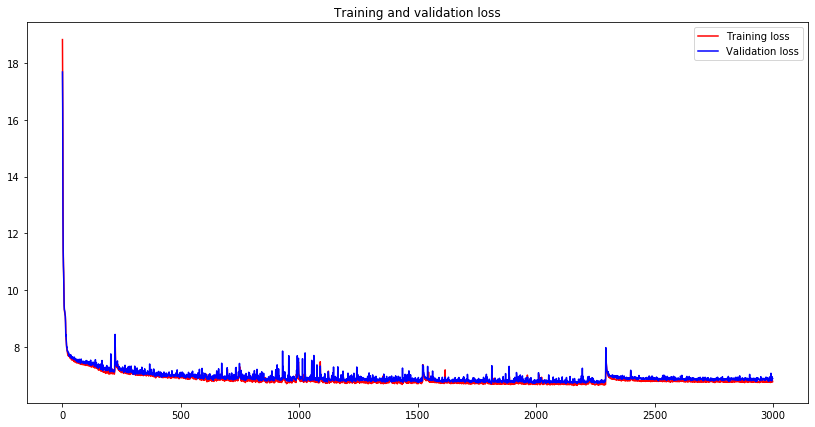

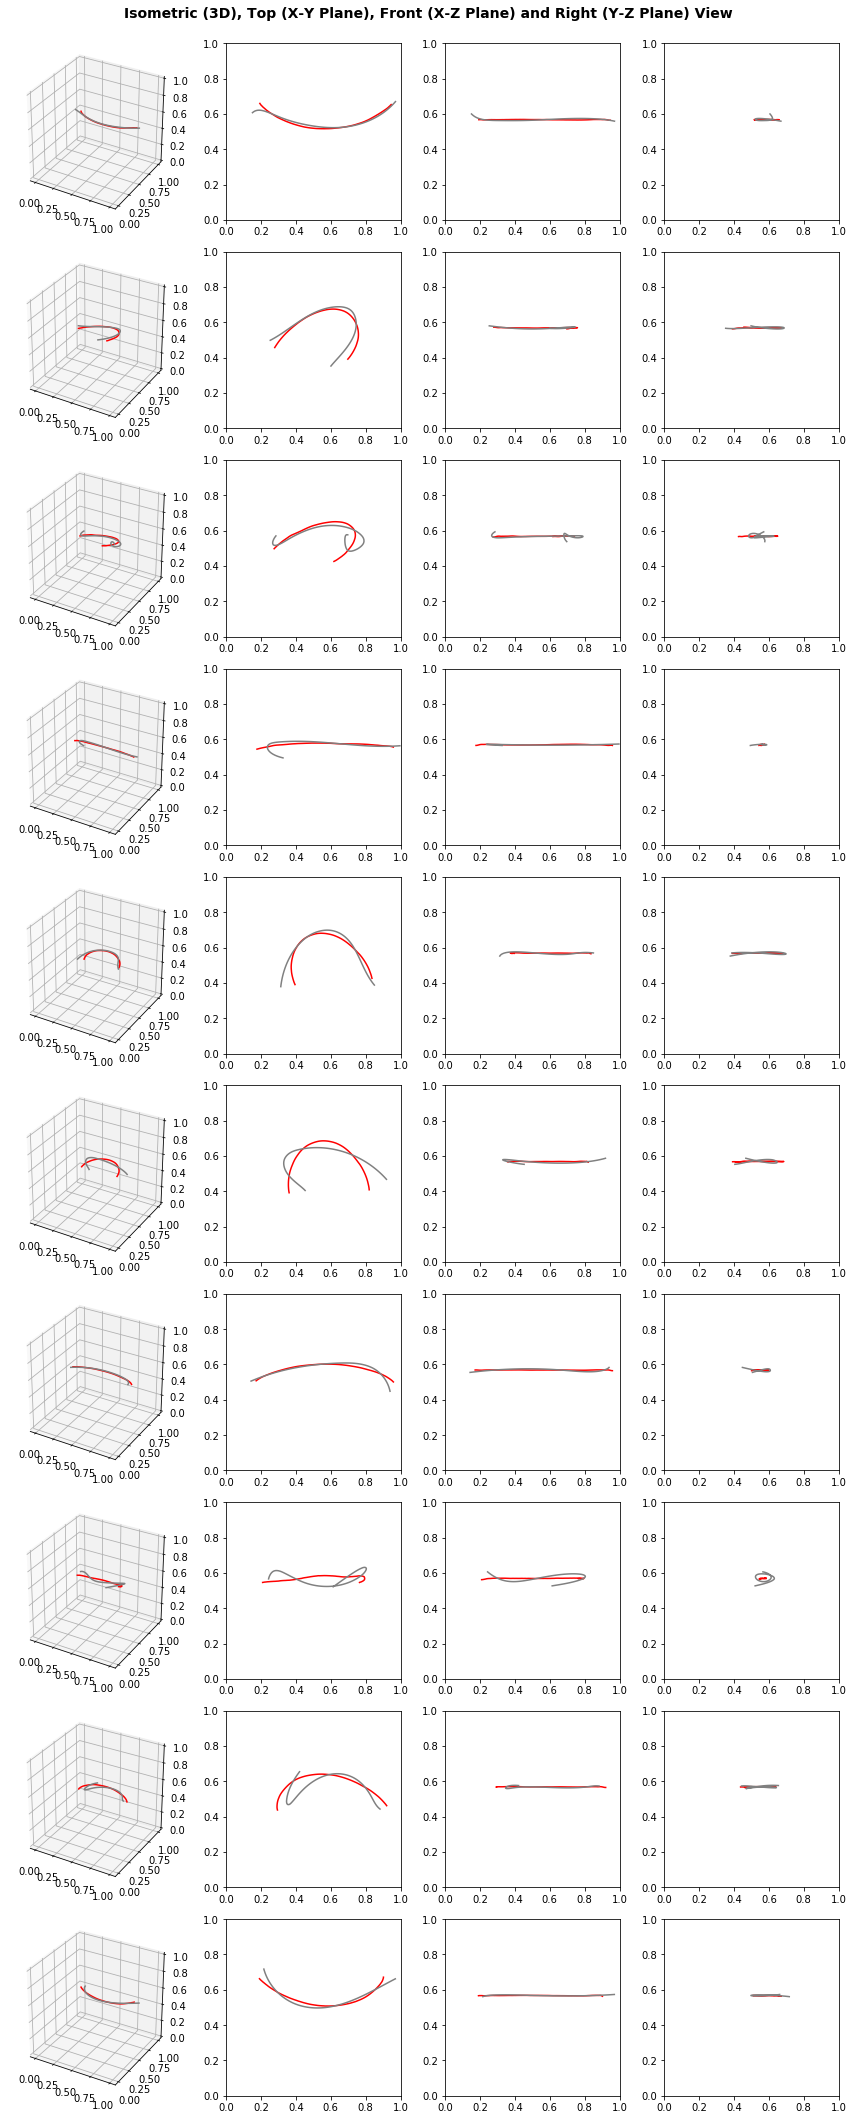

In [49]:
def visualize_train_curves(train_data):
    loss = train_data.history['loss']
    val_loss = train_data.history['val_loss']
    
    f_loss=np.round_(loss[-1],decimals=4)
    f_val_loss=np.round_(val_loss[-1],decimals=4)
    
    print('Training loss: '+str(f_loss))
    print('Validation loss: '+str(f_val_loss))
    
    epochsRange = range(len(loss))
    plt.figure(figsize=(14, 7))
    plt.plot(epochsRange[1:-1], loss[1:-1], 'r', label='Training loss')
    plt.plot(epochsRange[1:-1], val_loss[1:-1], 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

visualize_AE(vae, train_data, x_test, y_test)

## Fully Connected (hidden=2, Z=30)

In [ ]:
def VAE_FC_h2_Z30():
    z_dim=30
    inp=Input(shape=(100,3))

    # Encoding
    x=Flatten()(inp)
    x=Dense(150, activation='relu')(x)
    x=Dense(75, activation='relu')(x)
    z_mean = Dense(z_dim, name='z_mean')(x)
    z_log_var = Dense(z_dim, name='z_log_var')(x)
    z = Lambda(sampling, output_shape=(z_dim,), name='z')([z_mean, z_log_var])

    # Decoding
    x=Dense(75, activation='relu')(z)
    x=Dense(150, activation='relu')(x)
    x=Dense(300)(x)
    y=Reshape((100, 3))(x)
    
    # loss
    def reconstruction_loss(out_true, out_pred):
      return rmse(out_true, out_pred)
    def kl_loss(out_true, out_pred):
      return kl(z_mean,z_log_var)
    def vae_loss(out_true, out_pred):      
      return reconstruction_loss(out_true, out_pred) + kl_loss(out_true, out_pred)

    # build model
    vae = Model(inputs=[inp], outputs=[y])
    #vae.add_loss(vae_loss)
    vae.compile(optimizer='adam', loss=vae_loss, metrics=[reconstruction_loss,kl_loss])
    vae.summary()
    
    encoder = Model(inputs=[inp], outputs=[z_mean])
    return vae, encoder

vae,_=VAE_FC_h1_Z30()
SVG(model_to_dot(vae, show_shapes='true', show_layer_names='true', dpi=70).create(prog='dot', format='svg'))

## Cov2D (Z=30)

In [1]:
def VAE_Cov2D_Z30():
    z_dim=30
    inp=Input(shape=(100,3))

    # Encoding
    x= Reshape((100, 3, 1))(inp)
    x= Conv2D(15, (10,1), strides=(10, 1), activation='relu')(x)
    x= Conv2D(20, (2,1), strides=(2, 1), activation='relu')(x)
    x= Conv2D(25, (4,1), activation='relu')(x)
    x= Flatten()(x)
    x=Dense(90, activation='relu')(x)
    x=Dense(70, activation='relu')(x)
    x=Dense(50, activation='relu')(x)
    z_mean = Dense(z_dim, name='z_mean')(x)
    z_log_var = Dense(z_dim, name='z_log_var')(x)
    z = Lambda(sampling, output_shape=(z_dim,), name='z')([z_mean, z_log_var])

    # Decoding
    x=Dense(50, activation='relu')(z)
    x=Dense(70, activation='relu')(x)
    x=Dense(90, activation='relu')(x)
    x=Dense(150, activation='relu')(x)
    x= Reshape((2, 3, 25))(x)
    x= Conv2DTranspose(20, (4,1), activation='relu')(x)
    x= Conv2DTranspose(15, (2,1), strides=(2, 1), activation='relu')(x)
    x= Conv2DTranspose(1, (10,1), strides=(10, 1))(x)
    y= Reshape((100, 3))(x)
    
    # loss
    def reconstruction_loss(out_true, out_pred):
      return rmse(out_true, out_pred)
    def kl_loss(out_true, out_pred):
      return kl(z_mean,z_log_var)
    def vae_loss(out_true, out_pred):      
      return reconstruction_loss(out_true, out_pred) + kl_loss(out_true, out_pred)

    # build model
    vae = Model(inputs=[inp], outputs=[y])
    #vae.add_loss(vae_loss)
    vae.compile(optimizer='adam', loss=vae_loss, metrics=[reconstruction_loss,kl_loss])
    vae.summary()
    
    encoder = Model(inputs=[inp], outputs=[z_mean])
    return vae, encoder

vae,_=VAE_Cov2D_Z30()
SVG(model_to_dot(vae, show_shapes='true', show_layer_names='true', dpi=70).create(prog='dot', format='svg'))

NameError: ignored

In [0]:
#resetRNG(0)
#x_train_3D=np.expand_dims(x_train, 4)
#x_test_3D=np.expand_dims(x_test, 4)
#AE,E,train_data =AE_analysis(VAE_Z30, 10, x_train, x_test, filename='VAE_Z30')

train_data=vae.fit([x_train], [y_train], shuffle=True, epochs=500, batch_size=128, validation_data=([x_test], [y_test]), verbose=1)

In [ ]:
def visualize_train_curves(train_data):
    loss = train_data.history['loss']
    val_loss = train_data.history['val_loss']
    
    f_loss=np.round_(loss[-1],decimals=4)
    f_val_loss=np.round_(val_loss[-1],decimals=4)
    
    print('Training loss: '+str(f_loss))
    print('Validation loss: '+str(f_val_loss))
    
    epochsRange = range(len(loss))
    plt.figure(figsize=(14, 7))
    plt.plot(epochsRange[1:-1], loss[1:-1], 'r', label='Training loss')
    plt.plot(epochsRange[1:-1], val_loss[1:-1], 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

visualize_AE(vae, train_data, x_test, y_test)

## Model Inference

In [0]:
# Import autoencoder for z-space representation
import os
import numpy as np
from keras.models import Model, load_model

# Load Autoencoder model with Z=30
filename='AE_D3_val_loss_0.0049.h5'
path=os.path.join('models',filename)
AE_Z3 = load_model(path, custom_objects={'rmse': rmse})
E_Z3 = Model(AE_Z3.input, AE_Z3.layers[5].output)
E_Z3.summary()

z_param= E_Z3.predict(cplr_true)
print(z_param.shape)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100, 3)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 300)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 200)               60200     
_________________________________________________________________
dense_26 (Dense)             (None, 150)               30150     
_________________________________________________________________
dense_27 (Dense)             (None, 100)               15100     
_________________________________________________________________
dense_28 (Dense)             (None, 30)                3030      
Total params: 108,480
Trainable params: 108,480
Non-trainable params: 0
_____________________________________________________

In [0]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=500)
labels=clustering.fit_predict(z_param)
print(labels.shape)

In [0]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=500)
kmeans.fit(z_param)
labels=kmeans.predict(z_param)
centers = kmeans.cluster_centers_

Random index selected =  22


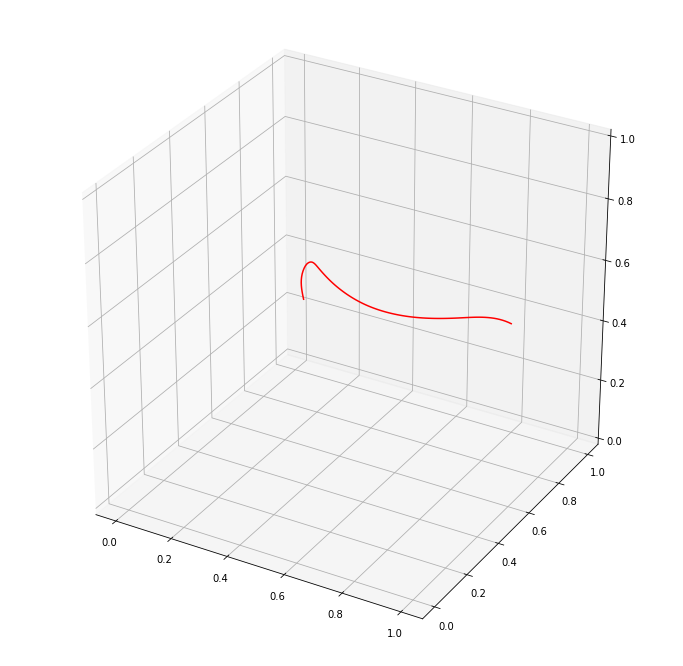

In [0]:
#Select an arbitrary path
n=random.randint(0, z_param.shape[0])
n=22 #22,49
print("Random index selected = ",n)
fig= plt.figure(figsize=(12, 12))
ax = plt.subplot(1, 1, 1, projection='3d')
plotPath3D(n_cplr_true[n], ax, 1,'r' )

In [0]:
current_dir=os.getcwd()
db_path=os.path.join(current_dir,'..','1. DB Preprocessing','db4_5SS_mirror_s20084.npz')
db = np.load(db_path)
print(db.files)
mech=db['mechData']
print(mech.shape)
# Renormalize DB from range [-1,1] to range [0,1] 
n_mech=mech/(np.abs(data_min)+data_max)+np.abs(data_min)

['cplrData', 'mechData']
(20084, 11, 3)


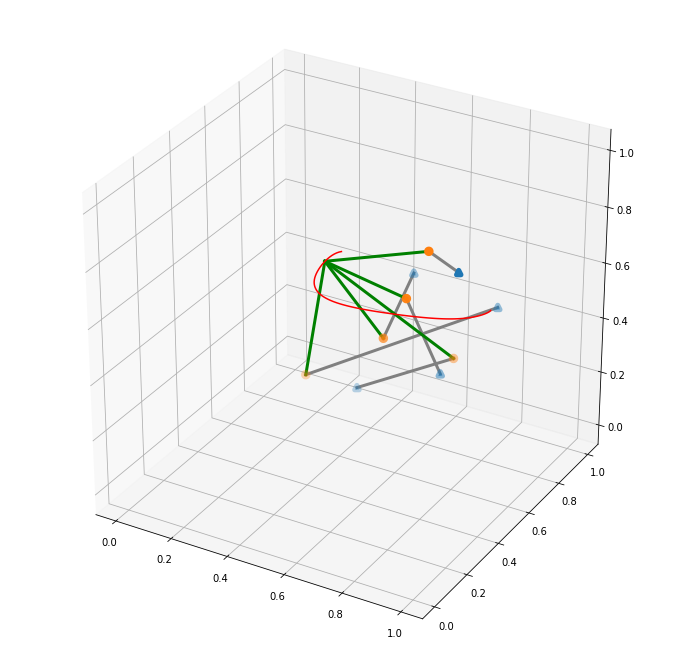

In [0]:
def plotLine3D(P1,P2,ax,color):
  ax.plot3D([P1[0],P2[0]], [P1[1],P2[1]], [P1[2],P2[2]],linewidth=3, color=color)

def plotMech5SS(mech,ax):
    Fp1=mech[0]; Fp2=mech[1];Fp3=mech[2]; Fp4=mech[3];Fp5=mech[4];
    Mp1=mech[5]; Mp2=mech[6];Mp3=mech[7]; Mp4=mech[8];Mp5=mech[9];
    C=mech[10];

    c1='grey'
    c2='g'
    plotLine3D(Fp1,Mp1,ax,c1)
    plotLine3D(Fp2,Mp2,ax,c1)
    plotLine3D(Fp3,Mp3,ax,c1)
    plotLine3D(Fp4,Mp4,ax,c1)
    plotLine3D(Fp5,Mp5,ax,c1)
    
    plotLine3D(Mp1,C,ax,c2)
    plotLine3D(Mp2,C,ax,c2)
    plotLine3D(Mp3,C,ax,c2)
    plotLine3D(Mp4,C,ax,c2)
    plotLine3D(Mp5,C,ax,c2)

    ax.scatter3D(mech[0:5,0],mech[0:5,1],mech[0:5,2],marker='^',linewidths=5)
    ax.scatter3D(mech[5:10,0],mech[5:10,1],mech[5:10,2],marker='o',linewidths=5)

i=7
fig= plt.figure(figsize=(12, 12))
ax = plt.subplot(1, 1, 1, projection='3d')
plotMech5SS(n_mech[i],ax)
plotPath3D(n_cplr_true[i], ax, 1,'r' )

91


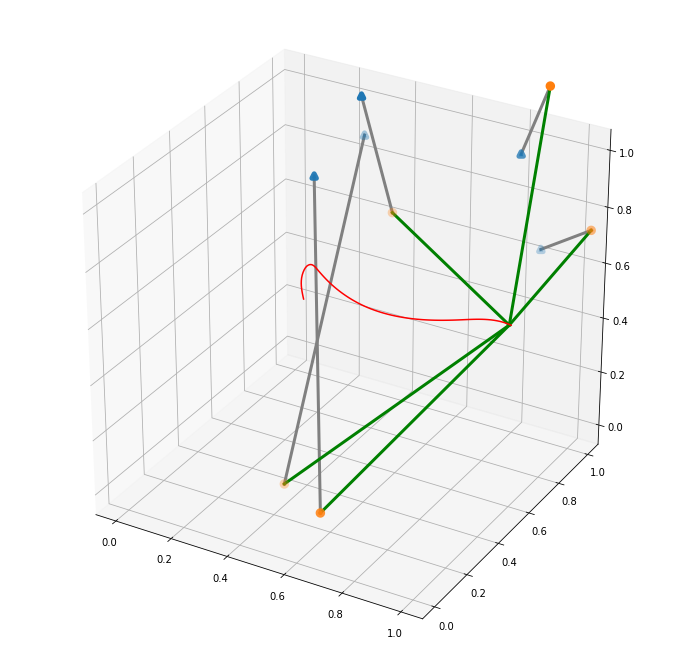

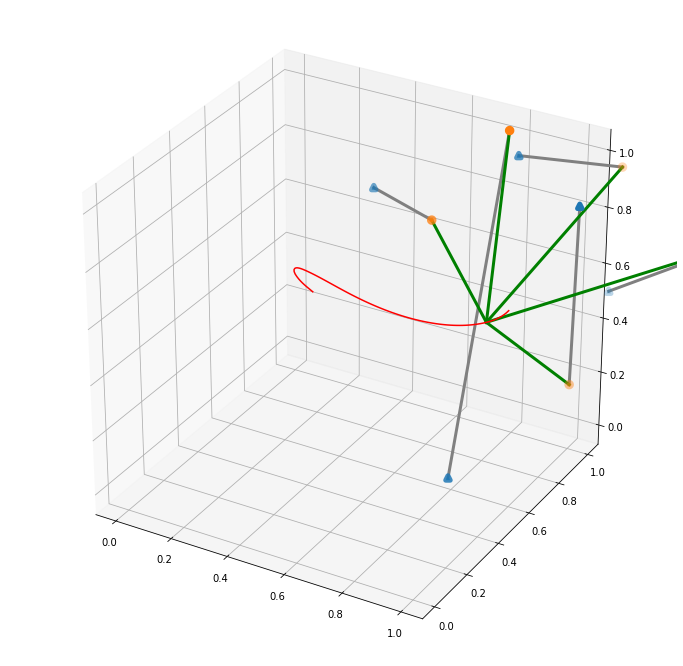

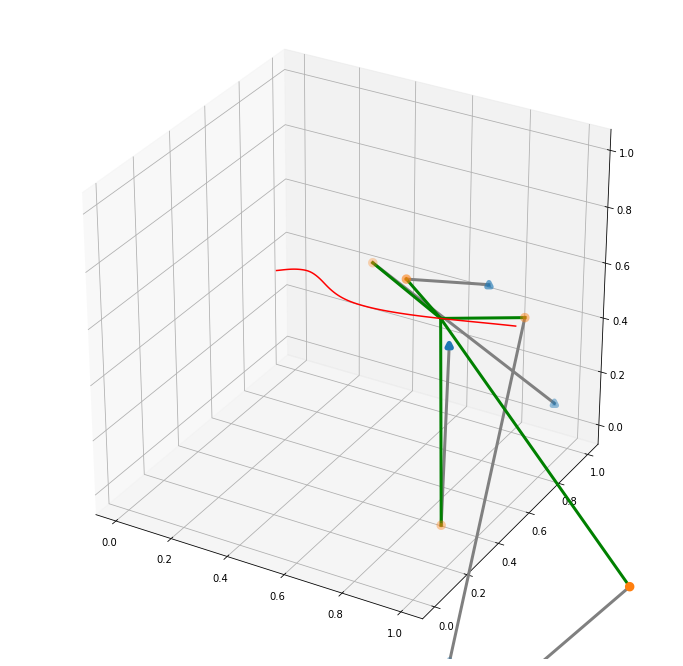

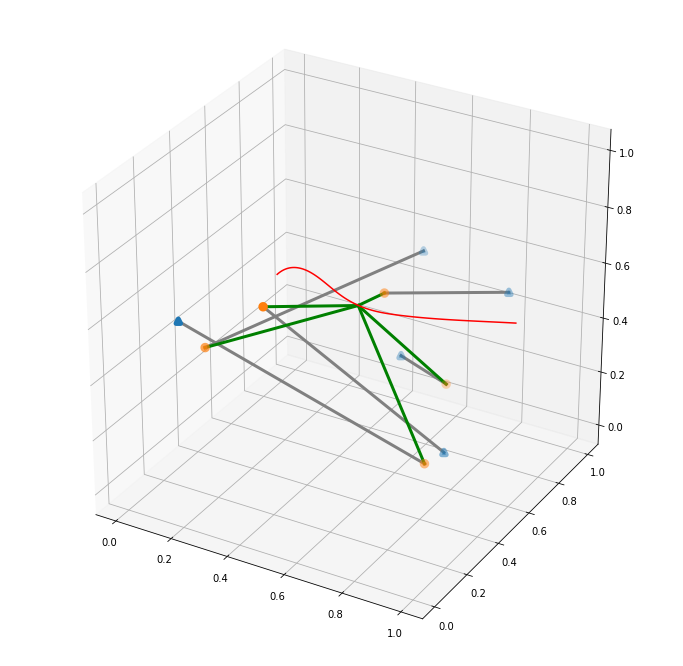

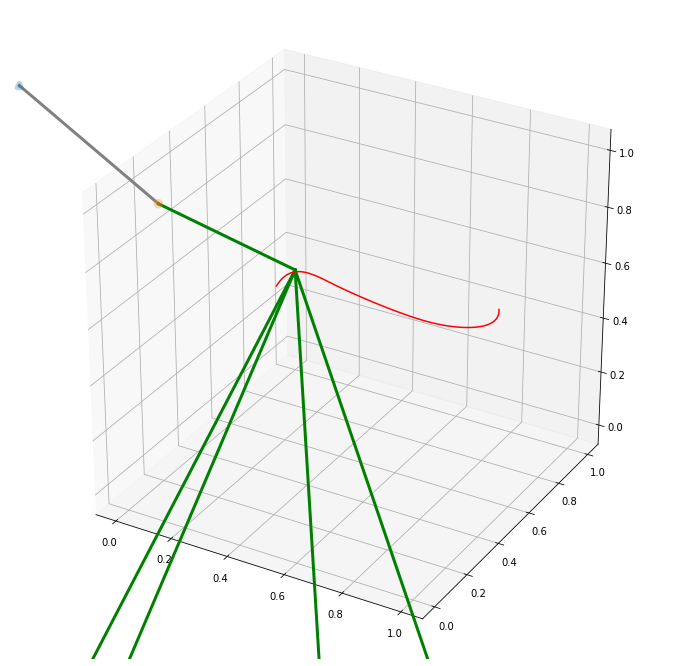

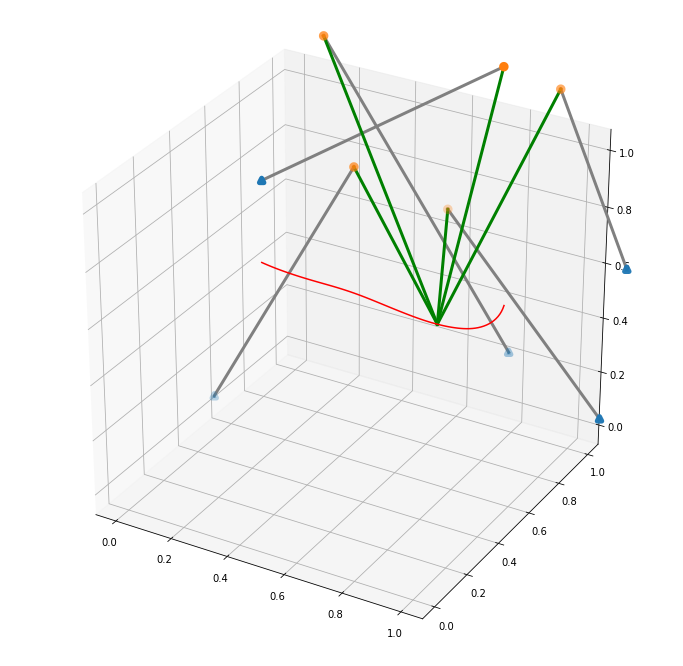

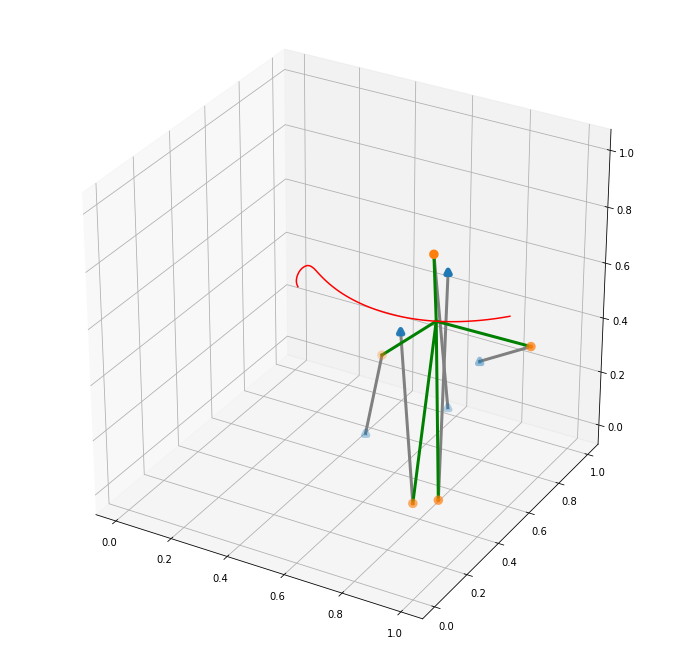

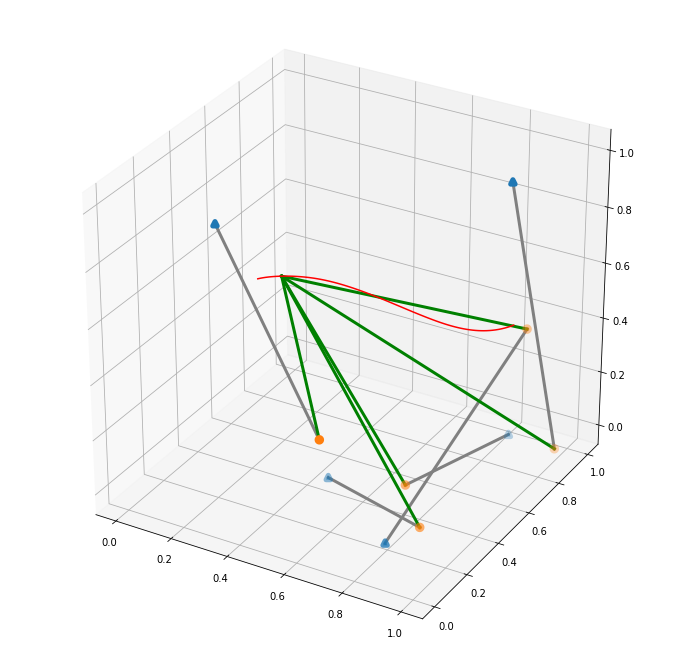

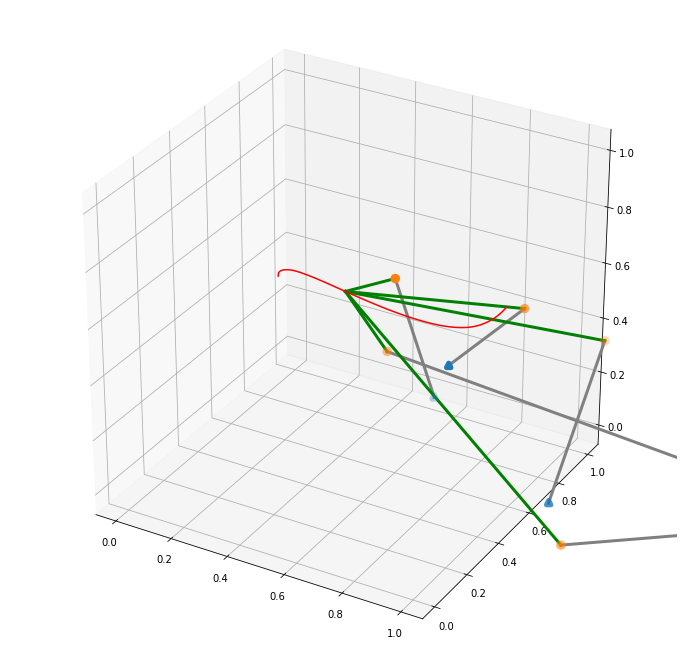

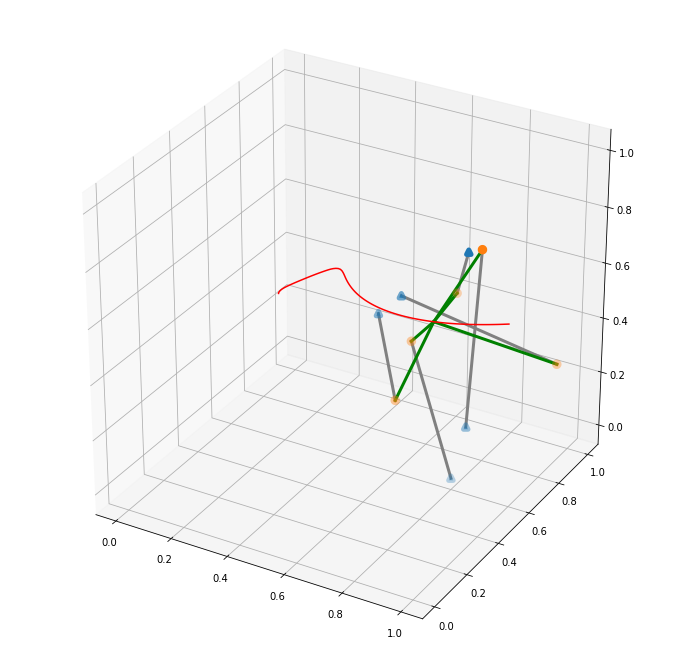

In [0]:
z_user=z_param[n]
minDist=99999999
group_id=-1
for i in range(500):
  d=np.linalg.norm(z_user-centers[i])
  if d<minDist:
    minDist=d
    group_id=i

sol=[]
for i in range(0,z_param.shape[0]):
  if labels[i]==group_id:
    sol.append(i)

for i in range(10):
    fig= plt.figure(figsize=(12, 12))
    ax = plt.subplot(1, 1, 1, projection='3d')
    plotMech5SS(n_mech[sol[i]],ax)
    plotPath3D(n_cplr_true[sol[i]], ax, 1,'r' )
    
print(len(sol))

# Conditional Variational Autoencoder (CVAE)

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 100, 3)       0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 100, 1)       0                                            
__________________________________________________________________________________________________
concatenate_13 (Concatenate)    (None, 100, 4)       0           input_15[0][0]                   
                                                                 input_16[0][0]                   
__________________________________________________________________________________________________
reshape_23 (Reshape)            (None, 100, 4, 1)    0           concatenate_13[0][0]      

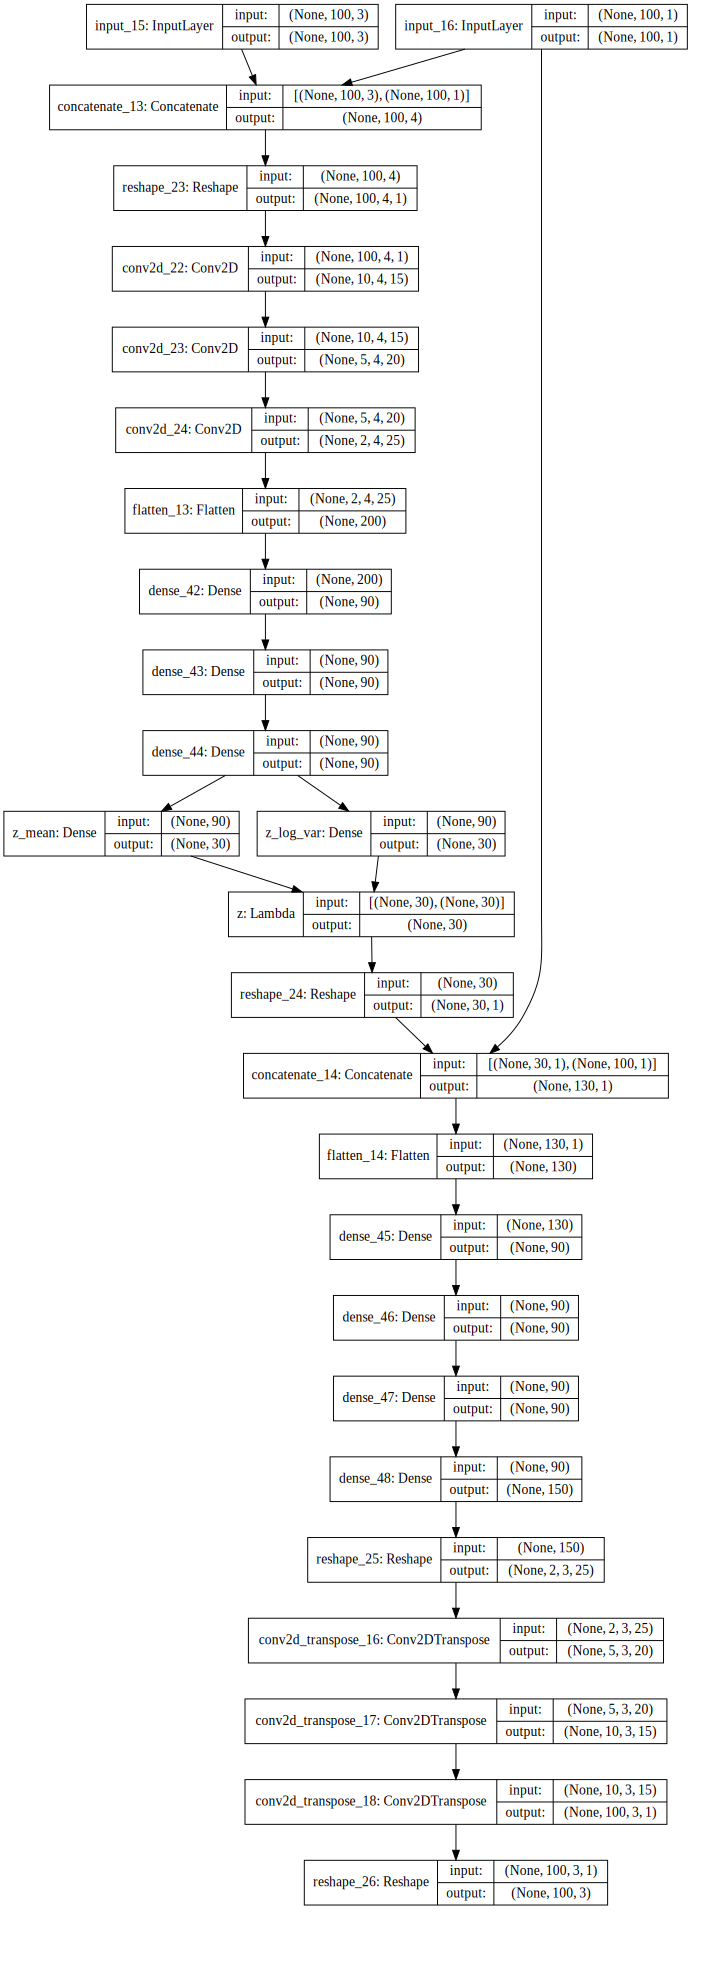

In [0]:
# Conditional VAE
# for path completion
# Train using mask and respective incomplete paths as input and full path as output.
def CVAE_Z30():
    z_dim=30
    inp=Input(shape=(100,3))
    condition=Input(shape=(100,1))

    # Encoding
    inp_cond= Concatenate()([inp, condition])
    x= Reshape((100, 4, 1))(inp_cond)
    x= Conv2D(15, (10,1), strides=(10, 1), activation='relu')(x)
    x= Conv2D(20, (2,1), strides=(2, 1), activation='relu')(x)
    x= Conv2D(25, (4,1), activation='relu')(x)
    x= Flatten()(x)
    x=Dense(90, activation='relu')(x)
    x=Dense(70, activation='relu')(x)
    x=Dense(50, activation='relu')(x)
    z_mean = Dense(z_dim, name='z_mean')(x)
    z_log_var = Dense(z_dim, name='z_log_var')(x)
    z = Lambda(sampling, output_shape=(z_dim,), name='z')([z_mean, z_log_var])

    # Decoding
    z = Reshape((z_dim, 1))(z)
    z_cond = Concatenate(axis=-2)([z, condition])
    x=Flatten()(z_cond)
    x=Dense(50, activation='relu')(x)
    x=Dense(70, activation='relu')(x)
    x=Dense(90, activation='relu')(x)
    x=Dense(150, activation='relu')(x)
    x= Reshape((2, 3, 25))(x)
    x= Conv2DTranspose(20, (4,1), activation='relu')(x)
    x= Conv2DTranspose(15, (2,1), strides=(2, 1), activation='relu')(x)
    x= Conv2DTranspose(1, (10,1), strides=(10, 1))(x)
    y= Reshape((100, 3))(x)
    
    # loss
    def reconstruction_loss(out_true, out_pred):
      return rmse(out_true, out_pred)
    def kl_loss(out_true, out_pred):
      return .1*kl(z_mean,z_log_var)
    def vae_loss(out_true, out_pred):   
      return reconstruction_loss(out_true, out_pred) + kl_loss(out_true, out_pred)

    # build model
    cvae = Model(inputs=[inp,condition], outputs=[y])
    #cvae.add_loss(vae_loss)
    cvae.compile(optimizer='adam', loss=vae_loss, metrics=[reconstruction_loss,kl_loss])
    cvae.summary()
    
    encoder = Model(inputs=[inp,condition], outputs=[z_mean])
    return cvae, encoder

cvae,_=CVAE_Z30()
SVG(model_to_dot(cvae, show_shapes='true', show_layer_names='true', dpi=70).create(prog='dot', format='svg'))

In [0]:
current_dir=os.getcwd()
db_path=os.path.join(current_dir,'..','1. DB Preprocessing','db6_5SS_noisy_s60252.npz')
db = np.load(db_path)
cplr_noisy=db['cplrData']
cplr_mask=np.expand_dims(db['cplrMask'], axis=-1)
print(cplr_noisy.shape)
print(cplr_mask.shape)

cplr_mir = import_DB('db4_5SS_mirror_s20084.npz')
db_part=[]
n_partial=2
for i in range(cplr_mir.shape[0]):
  for j in range(n_partial):
    db_part.append(cplr_mir[i])
cplr_true=np.append(cplr_mir,np.array(db_part),axis=0)
print(cplr_true.shape)

(60252, 100, 3)
(60252, 100, 1)
(60252, 100, 3)


In [0]:
data_max=np.max([np.max(cplr_noisy),np.max(cplr_true)])
data_min=np.min([np.min(cplr_noisy),np.min(cplr_true)])
print(data_max)
print(np.abs(data_min))

0.5583904768264918
0.5764223109354129


In [0]:
# Renormalize DB from range [-1,1] to range [0,1] 
n_cplr_true=cplr_true/(np.abs(data_min)+data_max)+np.abs(data_min)
n_cplr_noisy=cplr_noisy/(np.abs(data_min)+data_max)+np.abs(data_min)

In [0]:
x= n_cplr_noisy
y= n_cplr_true
mask=cplr_mask

# Split data into training and testing dataset
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test, m_train, m_test = train_test_split(x, y, mask, test_size=0.2, random_state=1)

print(x_train.shape)
print(y_train.shape)
print(m_train.shape)
print(x_test.shape)
print(y_test.shape)
print(m_test.shape)

(48201, 100, 3)
(48201, 100, 3)
(48201, 100, 1)
(12051, 100, 3)
(12051, 100, 3)
(12051, 100, 1)


In [0]:
train_data=cvae.fit([x_train,m_train], [y_train], shuffle=True, epochs=50, batch_size=128, validation_data=([x_test,m_test], [y_test]), verbose=1)

Train on 48201 samples, validate on 12051 samples
Epoch 1/50
48201/48201 [==============================] - 4s 91us/step - loss: 3.3432 - reconstruction_loss: 2.7580 - kl_loss: 0.5852 - val_loss: 3.4118 - val_reconstruction_loss: 2.8286 - val_kl_loss: 0.5833
Epoch 2/50
48201/48201 [==============================] - 4s 93us/step - loss: 3.3256 - reconstruction_loss: 2.7375 - kl_loss: 0.5881 - val_loss: 3.3651 - val_reconstruction_loss: 2.7731 - val_kl_loss: 0.5920
Epoch 3/50
48201/48201 [==============================] - 5s 111us/step - loss: 3.3255 - reconstruction_loss: 2.7383 - kl_loss: 0.5872 - val_loss: 3.4466 - val_reconstruction_loss: 2.8622 - val_kl_loss: 0.5843
Epoch 4/50
48201/48201 [==============================] - 5s 103us/step - loss: 3.3240 - reconstruction_loss: 2.7368 - kl_loss: 0.5872 - val_loss: 3.3826 - val_reconstruction_loss: 2.7867 - val_kl_loss: 0.5959
Epoch 5/50
48201/48201 [==============================] - 5s 99us/step - loss: 3.3093 - reconstruction_loss: 2.7

Training loss: 3.2138
Validation loss: 3.3216


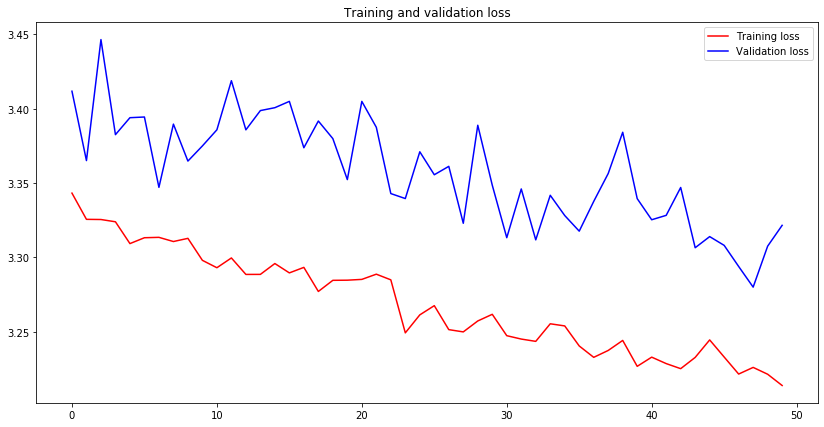

In [0]:
visualize_train_curves(train_data)

In [0]:
%matplotlib inline
#%matplotlib notebook

import numpy as np 
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from numpy import linalg as LA
#plt.style.use('dark_background')


def plotPath3D(Pts, ax, limit, color = 'gray'):
    xline=Pts[:,0]
    yline=Pts[:,1]
    zline=Pts[:,2]
    ax.plot3D(xline, yline, zline, color)
    ax.auto_scale_xyz([-limit, limit], [-limit, limit], [-limit, limit])
    plt.tight_layout()

def plotPath(Pts, ax, limit, color = 'gray'):
    xline=Pts[:,0]
    yline=Pts[:,1]
    ax.plot(xline, yline, color)
    ax.set(xlim=(0, limit), ylim=(0, limit))

def plotXYZ(center, RotMat, ax):
    C=np.vstack((center,center,center))
    R=RotMat
    r=(1,0,0)
    g=(0,1,0)
    b=(0,0,1)
    ax.quiver(C[:,0], C[:,1], C[:,2], R[:,0], R[:,1], R[:,2],color=(r,g,b,r,r,g,g,b,b))
    plt.tight_layout()


def visualizePaths(Paths,rows=10,cols=3, axlimit=.5):
    path_index=0;
    fig = plt.figure(figsize=2*plt.figaspect(rows/cols))
    for i in range(rows):
        for j in range(cols):
            Pts=Paths[path_index]
            path_index=path_index+1
            ax = fig.add_subplot(rows, cols, path_index, projection='3d')
            plotPath(Pts, ax, axlimit)
            #plotXYZ(np.zeros((1, 3)), np.identity(3), ax)
    plt.tight_layout()
    plt.show()

def visualizePathsRand(Paths,rows=10,cols=3, axlimit=.5):
    path_index=0;
    fig = plt.figure(figsize=2*plt.figaspect(rows/cols))
    for i in range(rows):
        for j in range(cols):
            Pts=Paths[np.random.randint(Paths.shape[0])]
            path_index=path_index+1
            ax = fig.add_subplot(rows, cols, path_index, projection='3d')
            plotPath(Pts, ax, axlimit)
            #plotXYZ(np.zeros((1, 3)), np.identity(3), ax)
    plt.tight_layout()
    plt.show()

In [0]:
reconst_curve = cvae.predict([x_train,m_train])

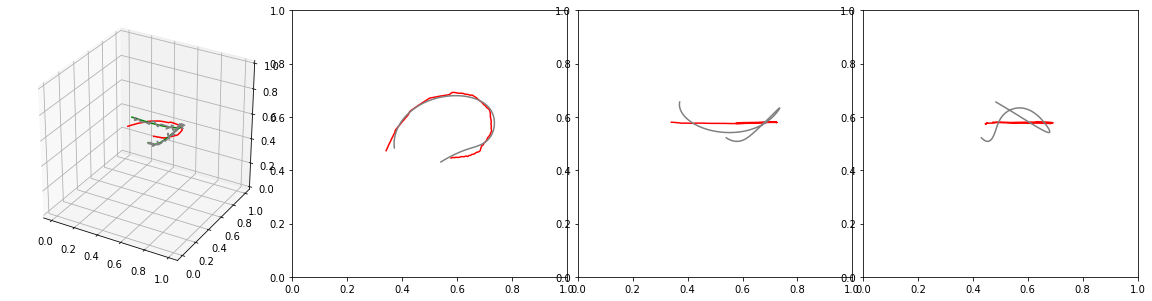

In [0]:
def plotPartialPath(Pts, mask, ax, limit, color = 'gray'):
    ind=np.nonzero(mask)
    xline=Pts[:,0]
    yline=Pts[:,1]
    zline=Pts[:,2]
    ax.plot3D(xline[ind[0]], yline[ind[0]], zline[ind[0]], color)
    ax.auto_scale_xyz([0, limit], [0, limit], [0, limit])
    plt.tight_layout()


i=4
orig=y_train[i]
recon=reconst_curve[i]

fig= plt.figure(figsize=(16, 4))
ax = plt.subplot(1, 4, 1, projection='3d')
#3D view
plotPath3D(reconst_curve[i],ax,1,'r')
plotPath3D(y_train[i],ax,1,'g')
plotPartialPath(x_train[i],m_train[i],ax,1)

#x-y, x-z, y-z plane view
xy_recon=recon[:,0:2]
xy_orig=orig[:,0:2]
xz_recon=np.concatenate(([recon[:,0]], [recon[:,2]]),axis=0).T
xz_orig=np.concatenate(([orig[:,0]], [orig[:,2]]),axis=0).T
yz_recon=recon[:,1:3]
yz_orig=orig[:,1:3]

# Top View
ax = plt.subplot(1, 4, 2)
plotPath(xy_recon, ax, 1,'r' )
plotPath(xy_orig, ax, 1)
    
# Front View
ax = plt.subplot(1, 4, 3)
plotPath(xz_recon, ax, 1,'r' )
plotPath(xz_orig, ax, 1)
       
# Right View
ax = plt.subplot(1, 4, 4)
plotPath(yz_recon, ax, 1,'r' )
plotPath(yz_orig, ax, 1)

plt.show()

# Shared-encoder CVAE

In [0]:
# Shared Encoder CVAE
# Has single encoder and multiple decoders
# Used to generate DeepFake/FaceSwap

def SE_CVAE_encoder():
    z_dim=30
    inp=Input(shape=(100,3))
    condition=Input(shape=(100,1))

    # Encoding
    inp_cond= Concatenate()([inp, condition])
    x=Flatten()(inp_cond)
    x=Dense(150, activation='relu')(x)
    x=Dense(150, activation='relu')(x)
    x=Dense(150, activation='relu')(x)
    z_mean = Dense(z_dim, name='z_mean')(x)
    z_log_var = Dense(z_dim, name='z_log_var')(x)
    z = Lambda(sampling, output_shape=(z_dim,), name='z')([z_mean, z_log_var])
    z = Reshape((z_dim, 1))(z)
    
    return Model(inputs=[inp,condition], outputs=[z,z_mean,z_log_var])
    
def SE_CVAE_decoder():
    z_dim=30
    z=Input(shape=(z_dim,1))
    condition=Input(shape=(100,1))

    # Encoding
    z_cond = Concatenate(axis=-2)([z, condition])
    x=Flatten()(z_cond)
    x=Dense(150, activation='relu')(x)
    x=Dense(150, activation='relu')(x)
    x=Dense(150, activation='relu')(x)
    x=Dense(300)(x)
    y=Reshape((100, 3))(x)
    
    return Model(inputs=[z,condition], outputs=[y])

def SE_CVAE():
    encoder = SE_CVAE_encoder()
    decoder_A = SE_CVAE_decoder()
    decoder_B = SE_CVAE_decoder()
    
    x = Input(shape=(100,3))
    m = Input(shape=(100,1))
    y1= decoder_A([encoder([x,m])[0],m])
    y2= decoder_B([encoder([x,m])[0],m])
    z_mean= encoder([x,m])[1]
    z_log_var= encoder([x,m])[2]
    print(z_mean)
    
    # loss
    reconstruction_loss1 = mse(x, y1)
    reconstruction_loss2 = mse(x, y2)
    kl_loss = 0.5 * K.sum(K.square(z_mean) + K.exp(z_log_var) - z_log_var - 1, axis = -1)
    vae_loss1 = reconstruction_loss1 + kl_loss
    vae_loss2 = reconstruction_loss2 + kl_loss    

    # build model
    SE_CVAE_1 = Model(inputs=[x,m], outputs=[y1])
    SE_CVAE_2 = Model(inputs=[x,m], outputs=[y2])
    SE_CVAE_1.add_loss(vae_loss1)
    SE_CVAE_2.add_loss(vae_loss2)
    
    SE_CVAE_1.compile(optimizer='adam')
    SE_CVAE_2.compile(optimizer='adam')
    SE_CVAE_1.summary()
    SE_CVAE_2.summary()
    
    return SE_CVAE_1, SE_CVAE_2, encoder

SE_CVAE_1,SE_CVAE_2,_=SE_CVAE()

Tensor("model_125/z_mean/BiasAdd:0", shape=(?, 30), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_290 (InputLayer)          (None, 100, 3)       0                                            
__________________________________________________________________________________________________
input_291 (InputLayer)          (None, 100, 1)       0                                            
__________________________________________________________________________________________________
model_125 (Model)               [(None, 30, 1), (Non 114510      input_290[0][0]                  
                                                                 input_291[0][0]                  
__________________________________________________________________________________________________
model_126 (Model)               (None, 100

In [0]:
pbar = tqdm(range(100))
for epoch in pbar:
    autoencoder_A.fit(first_training, first_classes, batch_size=32, nb_epoch=1)
    autoencoder_B.fit(first_training, first_classes, batch_size=32, nb_epoch=1)
    #loss_A = autoencoder_A.train_on_batch([warped_A,mask_A], [target_A,mask_A])
    #loss_B = autoencoder_B.train_on_batch([warped_B,mask_B], [target_B,mask_B])
    #pbar.set_description("Loss A [{}] Loss B [{}]".format(loss_A,loss_B))
    #Track best model
    
    

NameError: name 'tqdm' is not defined

In [0]:
# Disentangling VAE

In [0]:
# Deep feature consistent variational auto-encoder
# using 'feature perceptual loss' instead of 'reconstruction loss'
# needs a pre-trained 'perception model'

In [0]:
# use domain knowledge and use multiple parallel input lambda layers for FDs, CAD, wavelets, etc